# \<Title\>

Imports

In [2]:
import os
import sys
import logging
import datetime
import dill as pickle
import matplotlib.pyplot as plt

Import custom libraries

In [3]:
# original py files
sys.path.insert(1, r'W:\OneDrive - TU Eindhoven\DS&AI\2024-2025\2024-2025 q1\2AMM20 - Research Topics in Data Mining\Research Project Phase\new_code\methods')

from data_methods import getData, standardize
from dimensionality_reduction import reduce_dimensionality,reduce_with
from beamSearch import EMM, as_string
from adjPysubgroup import adjustedBestFirstSearch, adjustedDFS, adjustedApriori
from qualityMeasures import calc_result_bs, calc_result_ps

## 1. Functions

In [20]:
def export_results(save_path,file_name,data):
    """Function to export the data to a temporary or final file.
    save_path: directory/folder to which the data should be saved.
    file_name: name of the file
    data: data that should be saved
    """
    file_path = os.path.join(save_path,file_name)
    with open(file_path,'wb') as f:
        pickle.dump(data,f)
    
    logging.info(f"{'Temporary r' if 'temp' in file_name else 'R'}esults saved to {file_path}")


def run_search_method(search_method, method_name, df, save_path, reduction_method):
    """
    Method that runs a search method for the original and the encoded data, and returns the results in a dictionary 
    search_method: search method which is a function
    method_name: name of the search method to create temporary file_name
    df: input dataframe
    save_path: path to which temporary data should be saved
    """
    # original data
    start_time = datetime.datetime.now()
    results = search_method(df)
    if 'BS' not in method_name:
        results['subgroup'] = results['subgroup'].apply(lambda x: str(x))
    running_time = datetime.datetime.now() - start_time

    data = {
        'results_org': results,
        'running_time_org': running_time,
    }

    export_results(save_path,f'temp-results-{method_name}-{reduction_method}.pkl',data)

    return data


def get_results_dataset(dataset_name : str, optimal_features: dict, num_epochs = 100, save_path = 'sd_results',dct_data=None):

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # ---------=| open data |=---------
    logging.info(f'Opening the {dataset_name} dataset...')
    df, cat, num, features = getData(dataset_name)

    # ---------=| reduce dimensionality |=---------
    if dct_data is None:
        logging.info('Reducing dimensionality...')
        dct_data={
            'vanilla': df.copy(),
        }

        for reduction_method in ['auto_encoder', 'PCA', 'SPCA']:
            df_encoded,_ = reduce_dimensionality(
                    data=df,
                    reduction_method=reduction_method,
                    catColumns=cat,
                    numColumns=num, 
                    nFeatures=optimal_features[reduction_method],
                    nEpochs=num_epochs
                )
            
            dct_data[reduction_method]=df_encoded.copy()
            # temporary export as safety feature
            export_results(save_path,f'{dataset_name}-temp-results-reductions-{reduction_method}.pkl',dct_data)
        
        # export all data
        export_results(save_path,f'{dataset_name}-data-reductions.pkl',dct_data)
    else:
        logging.info('Data was already reduced')


    # ---------=| find subgroups |=---------
    logging.info('Finding subgroups...')

    beamSearch = lambda df_: EMM(100, 3, 100, [], df_, features, 'target', ensure_diversity=True,prnt=False)
    dct_results = {}

    # iterate over all types of dimensionality reduction and all search methods
    for reduction_method in ['vanilla', 'auto_encoder', 'PCA', 'SPCA']:

        # - Best-First Search
        dct_bfs = run_search_method(adjustedBestFirstSearch,f'BFS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        # - Depth-First Search
        dct_dfs = run_search_method(adjustedDFS,f'DFS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        # - Apriori
        dct_apri = run_search_method(adjustedApriori,f'APRI-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        # - Beam Search      
        dct_bs = run_search_method(beamSearch,f'BS-{dataset_name}',dct_data[reduction_method],save_path, reduction_method)

        # save results to overall dictionary
        dct_results[reduction_method] = {
            'Best-First Search':dct_bfs,
            'Depth-First Search':dct_dfs,
            'Apriori':dct_apri,
            'Beam Search':dct_bs
        }

        # save intermediate results
        now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
        export_results(save_path,f'{dataset_name}-temp-results-{reduction_method}-{now}.pkl',dct_results)
    
    # ---------=| export all results |=---------
    logging.info("Exporting Results...")

    now = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
    export_results(save_path,f'{dataset_name}-results-{now}.pkl',dct_results)
    
    return dct_results

## 2. Find Optimal Numbers of Features

In [5]:
def plot_mse_vs_nfeatures(dct_datasets,name_dataset,reduction_method,l_est,r_est):

    df = dct_datasets[name_dataset]['df']
    cat = dct_datasets[name_dataset]['cat']
    num = dct_datasets[name_dataset]['num']

    start_time = datetime.datetime.now()
    mseList = []

    for i in range(l_est, r_est+1):

        _,mse = reduce_dimensionality(
                    data=df,
                    reduction_method=reduction_method,
                    catColumns=cat,
                    numColumns=num, 
                    nFeatures=i,
                    nEpochs=100
                )

        mseList.append(mse)

    running_time = datetime.datetime.now()-start_time

    plt.plot([i for i in range(l_est, r_est+1)], mseList)
    plt.xlabel("Nr of Features") # ! new
    plt.ylabel("MSE") # ! new
    plt.show()

    logging.info(running_time)

In [6]:
# get all datasets
lst_dataset_names = ["Ionosphere","Mushroom","Adult","Soybean","Arrhythmia","Indoor"]
dct_datasets = {name:{key:val for val,key in zip(getData(name),['df','cat','num','features'])} for name in lst_dataset_names}

# define min and max estimates of nr of features
l_est,r_est=2,12
dct_optimal_features = {}

### 2.1 Ionosphere

In [7]:
dct_ion = {}

#### 2.1.1 Auto-Encoder

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


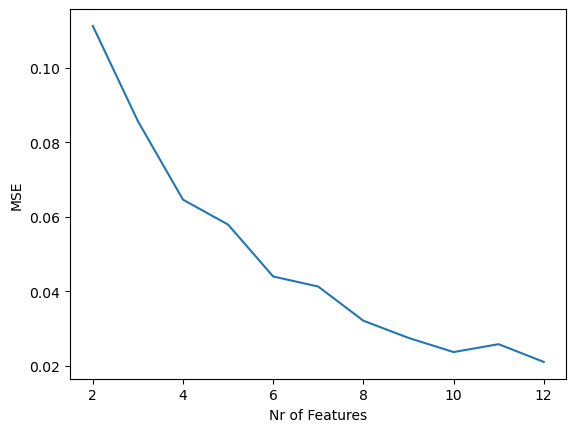

In [7]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','auto_encoder',l_est,r_est)

In [8]:
dct_ion['auto_encoder'] = 5

#### 2.1.2 PCA

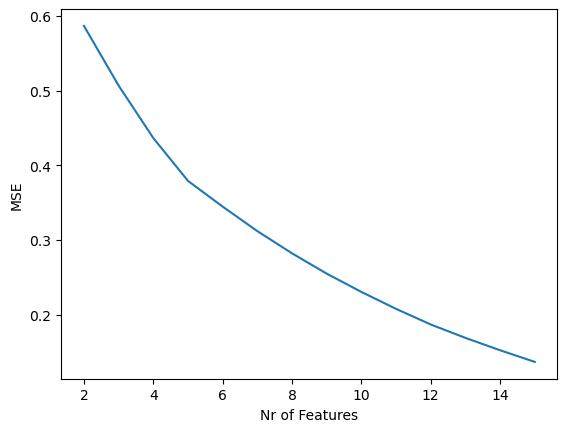

In [9]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','PCA',l_est,r_est=15)

In [10]:
dct_ion['PCA'] = 5 

#### 2.1.3 Sparse-PCA

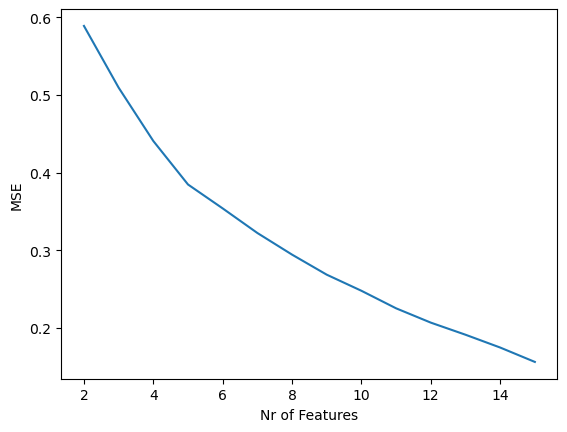

In [14]:
plot_mse_vs_nfeatures(dct_datasets,'Ionosphere','SPCA',l_est,r_est=15)

In [ ]:
dct_ion['SPCA'] = 5 

### 2.2 Mushroom

In [8]:
dct_shroom = {}

#### 2.2.1 Auto-Encoder

In [16]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','auto_encoder',l_est,r_est)

254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


KeyboardInterrupt: 

In [ ]:
dct_shroom['auto_encoder'] = ...

#### 2.2.1 PCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','PCA',l_est,r_est=15)

In [ ]:
dct_shroom['PCA'] = ...

#### 2.2.3 SPCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Mushroom','SPCA',l_est,r_est=15)

In [ ]:
dct_shroom['SPCA'] = ...

### 2.3 Adult

In [9]:
dct_adult = {}

#### 2.3.1 Auto-Encoder

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','auto_encoder',l_est,r_est)

In [ ]:
dct_adult['auto_encoder'] = ...

#### 2.3.2 PCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','PCA',l_est,r_est=15)

In [ ]:
dct_adult['PCA'] = ...

#### 2.3.3 SPCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Adult','SPCA',l_est,r_est=15)

In [ ]:
dct_adult['SPCA'] = ...

### 2.4 Soybean

In [14]:
dct_soy = {}

#### 2.4.1 Auto-Encoder

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','auto_encoder',l_est,r_est)

In [ ]:
dct_soy['auto_encoder'] = ...

#### 2.4.2 PCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','PCA',l_est,r_est=15)

In [ ]:
dct_soy['PCA'] = ...

#### 2.4.3 SPCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Soybean','SPCA',l_est,r_est=15)

In [ ]:
dct_soy['SPCA'] = ...

### 2.5 Arrhythmia

In [17]:
dct_arrh = {}

#### 2.5.1 Auto-Encoder

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','auto_encoder',l_est,r_est)

In [ ]:
dct_arrh['auto_encoder'] = ...

#### 2.5.2 PCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','PCA',l_est,r_est=15)

In [ ]:
dct_arrh['PCA'] = ...

#### 2.5.3 SPCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Arrhythmia','SPCA',l_est,r_est=15)

In [ ]:
dct_arrh['SPCA'] = ...

### 2.6 Indoor

In [16]:
dct_indoor = {}

#### 2.6.1 Auto-Encoder

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','auto_encoder',l_est,r_est)

In [ ]:
dct_indoor['auto_encoder'] = ...

#### 2.6.2 PCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','PCA',l_est,r_est=15)

In [ ]:
dct_indoor['PCA'] = ...

#### 2.6.3 SPCA

In [ ]:
plot_mse_vs_nfeatures(dct_datasets,'Indoor','SPCA',l_est,r_est=15)

In [ ]:
dct_indoor['SPCA'] = ...

### 2.7 General Dictionary

In [21]:
dct_opt_feat = {
    'Ionosphere':dct_ion,
    'Mushroom':dct_shroom,
    'Adult':dct_adult,
    'Soybean':dct_soy,
    'Arrhythmia':dct_arrh,
    'Indoor':dct_indoor
}

## 3. Get Results

In [24]:
# get all combinations of dataset & reduction method
for dataset_name,optimal_features in dct_opt_feat.items():
    dct_results = get_results_dataset(dataset_name, optimal_features)

## 4. Analyze Subgroups

In [12]:
# calc_result_ps(df_en, df, results_df_apri_en, results_df_apri,reduction_method)

In [25]:
...

Ellipsis

## 5. Interpretability Measures

In [13]:
...

Ellipsis